Risa made a suggestion for what to do next. She suggested that a simpler version would be to have the sampler guess which of the known masses is correct for a particular richness. It's a step back from sampling the mass function directly. 

I still haven't decided if the sampler should be looking for indicies or a mass directly; I'm not even sure how the latter would work. As I think about it I also wonder if this will have problems with guessing "bad" indicies, like <0 or >max_idx. I don't know how often something like that will happen; only one way to find out I guess.

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [48]:
from astropy.io import fits
#dataDir = '/home/sean/Data/BuzzardSims/'
dataDir = '/nfs/slac/g/ki/ki19/des/erykoff/clusters/mocks/Buzzard/buzzard-1.1/des_y5/redmapper_v6.4.7/halos/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

nData = 10

import numpy as np
mass = data['M200'][:nData]
print 'Rows:\t%d'%mass.shape[0]
redshifts = data['Z'][:nData]

mass = mass[redshifts<0.9]#Take only the first bin
redshifts = redshifts[redshifts<0.9]

logMass = np.log10(mass)

Rows:	10


In [49]:
M_piv = 2.35e14
logL0_true = 3.141
a_true, b_true = 0.842, -0.03
B_l_true = 0.642
sigma_l_true = 0.184

def _A_lam(a, b, z):
    return a*pow((1+z)/1.3, b)
_A_lam = lambda a,b,z : a*pow((1+z)/1.3, b)

from scipy.stats import norm
#forward model
def logLam(logLam0, a, b, B_lam, z, M):
    A_lam = _A_lam(a,b,z)
    return logLam0+A_lam*np.log(M/M_piv)+B_lam*np.log((1+z)/1.3)

def logLamSample(logL0, a, b, B_l,sigma_l, z,M):
    return norm.rvs(loc = logLam(logL0, a, b, B_l, z, M), scale = sigma_l)

In [50]:
logRichness = logLamSample(logL0_true, a_true, b_true, B_l_true, sigma_l_true, redshifts, mass)

In [51]:
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0e14, 1.0e14]#*10^14
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

#tools for mass function
#interpolates naively between the points given in the original paper
from scipy.stats import linregress
z_params = {}
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)

#return the values of the parameters at a given z.
getMassParams = lambda z : {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def log_n_approx(m,z):
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [52]:
from scipy.stats import gamma, norm, expon
def log_prior(logL0, a,b,B_l, sigma, M_idx):
    
    if any(x<0 for x in (logL0,sigma)):
        return -np.inf
    
    if np.any(M_idx < 0) or np.any(M_idx>=M_idx.shape[0]):
        return -np.inf

    t1 = np.arctan(B_l)
    t2 = np.arctan(a)
    #if t<0 or t>np.pi/2:
    if any(x< -np.pi/2 or x> np.pi/2 for x in (t1,t2)):
        return -np.inf
    
    #Hyperparameters
    lambda_logL0 = 1.0
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in logL0
    p+= expon.logpdf(logL0, scale = 1/lambda_logL0)
    #Uniform in arctan(B_l) and arctan(a)
    p+=2*np.log(1/np.pi)
    #flat prior for b
    #Have not idea what it would be, start with nothing
    #p+=0
    
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma**2,sigma_a, scale = sigma_b)
    return p

def log_liklihood(logL0, a,b, B_l, sigma, M_idx, z, logRich):
    p = 0
    #get masses
    M = mass[M_idx]
    #Mass function
    p+=np.sum(log_n_approx(M, z))
    #liklihood of richness
    p+=np.sum(norm.logpdf(logRich, loc =logLam(logL0, a, b, B_l, z, M), scale = sigma))
    return p

def log_posterior(theta,z, logRich):
    #print theta
    logL0,a,b, B_l, sigma = theta[:5]
    M_idx = theta[5:].astype(int) #cast to ints
    p = log_prior(logL0, a,b, B_l, sigma, M_idx)
    if np.isfinite(p):
        p+=log_liklihood(logL0,a,b, B_l, sigma,M_idx, z, logRich)
    return p

In [53]:
nCores = 4
nWalkers = 1000
nSteps = 1000
#set up sampler
ndim = 5 + logRichness.shape[0]
if 2*ndim>nWalkers:
    nWalkers = 2*ndim
    print 'nWalkers changed to %d to fit number of dimensions'%nWalkers

logL0_a, logL0_b = 1, 1 # Gamma
a_mean, a_spread = 1, 1.5
b_mean, b_spread = 0, .5
B_l_mean, B_l_spread = 1, 1.5
sigma_a, sigma_b = 1, 1 #Gamma

pos0 = np.zeros((nWalkers, ndim))
for row in pos0:

    row[0] = gamma.rvs(logL0_a, scale = logL0_b)
    row[1] = norm.rvs(loc = a_mean, scale = a_spread)
    row[2] = norm.rvs(loc = b_mean, scale = b_spread)
    row[3] = norm.rvs(loc = B_l_mean, scale = B_l_mean)
    row[4] = gamma.rvs(sigma_a, scale = sigma_b)
    row[5:] = np.random.choice(logRichness.shape[0], size = logRichness.shape[0], replace = True)

In [54]:
#I think sorting the mass will help. 
#idxs = np.argsort(mass)
#logRichness = logRichness[idxs]
#redshifts = redshifts[idxs]
#mass = mass[idxs]

In [55]:
import emcee as mc
sampler = mc.EnsembleSampler(nWalkers, ndim, log_posterior, args=[redshifts, logRichness],threads = nCores)

In [56]:
sampler.run_mcmc(pos0, nSteps);

In [57]:
nburn = int(nSteps)/10
chain = sampler.chain[:,nburn:, :].reshape((-1, ndim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain[:, :5].mean(axis = 0)
print MAP
labels = ['logL0', 'a', 'b','B_l','sigma']
print '\tMCMC\tTrue'
for label, val, truth in zip(labels, MAP, [logL0_true, a_true, b_true, B_l_true, sigma_l_true]):
    print '%s:\t%.3f\t%.3f'%(label, val, truth)

[  13.74936324 -158.70690975   20.28249163   13.9223963    75.64923152]
	MCMC	True
logL0:	13.749	3.141
a:	-158.707	0.842
b:	20.282	-0.030
B_l:	13.922	0.642
sigma:	75.649	0.184


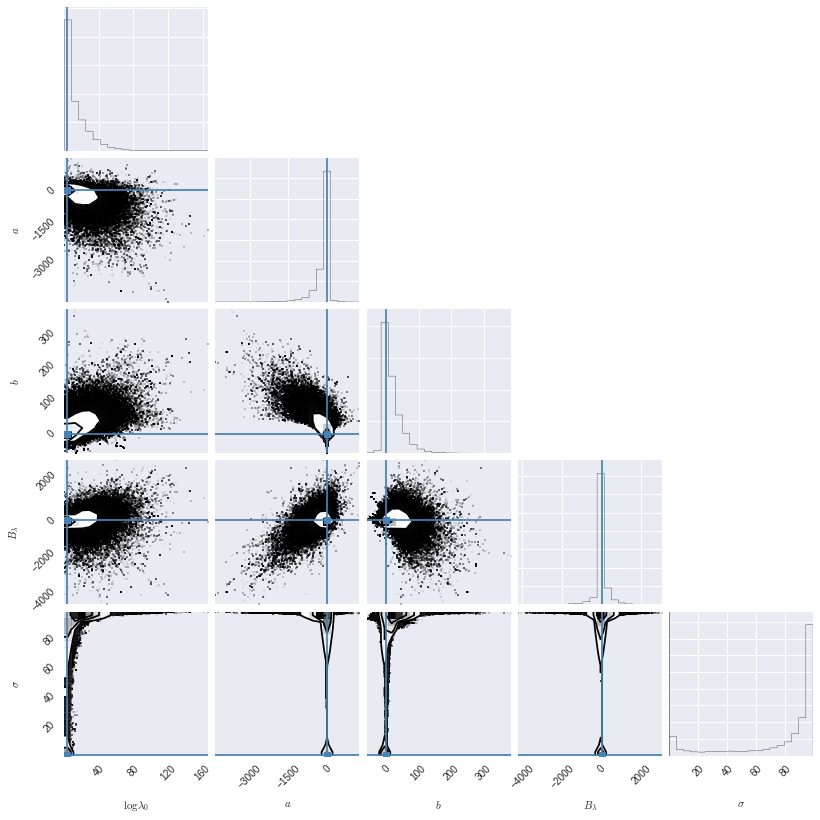

In [58]:
from corner import corner
titles = ['$\log{\lambda_0}$', '$a$', '$b$', '$B_{\lambda}$', '$\sigma$']
corner(chain[:, :5], labels = titles , truths = [logL0_true, a_true, b_true, B_l_true, sigma_l_true]);

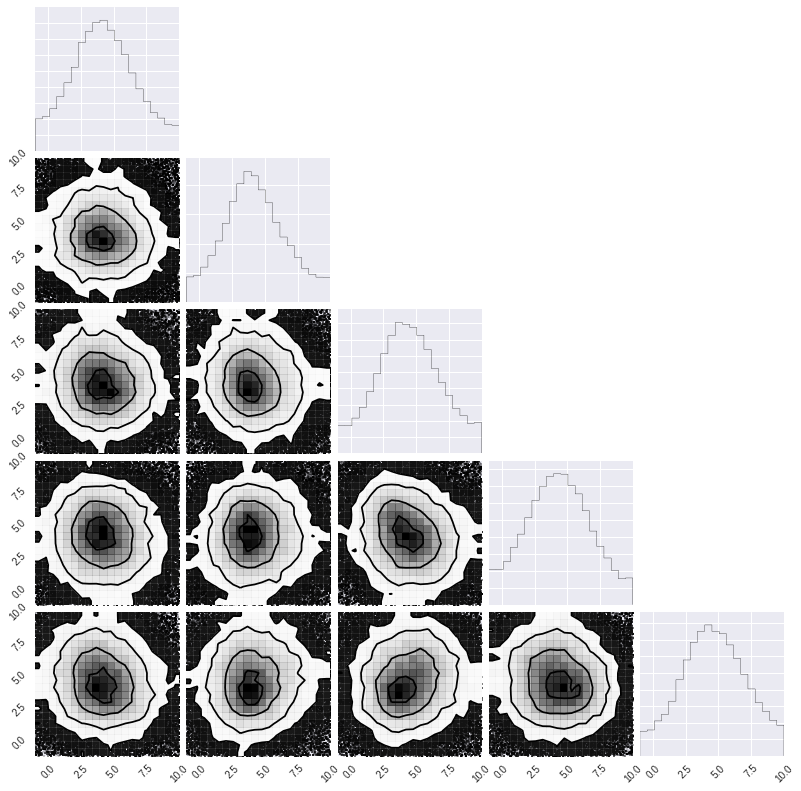

In [59]:
corner(chain[:, 5:10]);